# titanic호 탑승객의 생존유무(survived) 예측

In [1]:
import pandas as pd
import numpy as np
import random as rnd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [4]:
%cd C://python

C:\python


In [5]:
import easydict
args = easydict.EasyDict()

# path 정보
args.train_csv = 'titanic/train.csv' 
args.test_csv = 'titanic/test.csv'
args.default_submission_csv = 'titanic/submission.csv'

args.submission_csv ='submission_0405.csv'
args.save_results = "model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 21
args.results = []

## 데이터 불러오기

- survived : 생존=1, 죽음=0
- pclass : 승객 등급. 1등급=1, 2등급=2, 3등급=3
- sibsp : 함께 탑승한 형제 또는 배우자 수
- parch : 함께 탑승한 부모 또는 자녀 수
- ticket : 티켓 번호
- cabin : 선실 번호
- embarked : 탑승장소 S=Southhampton, C=Cherbourg, Q=Queenstown

In [6]:
raw_train = pd.read_csv(args.train_csv) 
raw_test = pd.read_csv(args.test_csv)

raw_train.shape, raw_test.shape   

((916, 12), (393, 11))

In [7]:
raw_train.columns  

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [8]:
raw_train['passengerid'].nunique()

916

In [9]:
#passengerid는 모두 다른 값이므로 삭제
del raw_train['passengerid']

In [10]:
raw_test.set_index(['passengerid'], inplace=True) 
print(f'{raw_test.shape}')

(393, 10)


In [11]:
raw_train.shape , raw_test.shape

((916, 11), (393, 10))

In [12]:
raw_train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [13]:
raw_test.columns

Index(['pclass', 'name', 'gender', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked'],
      dtype='object')

## train_test_split

raw train data -> train, test로 분리

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train, test = train_test_split(raw_train, test_size=0.3, stratify=raw_train['survived'],random_state=args.random_state) 

In [16]:
train.shape, test.shape

((641, 11), (275, 11))

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  641 non-null    int64  
 1   pclass    641 non-null    int64  
 2   name      641 non-null    object 
 3   gender    641 non-null    object 
 4   age       512 non-null    float64
 5   sibsp     641 non-null    int64  
 6   parch     641 non-null    int64  
 7   ticket    641 non-null    object 
 8   fare      641 non-null    float64
 9   cabin     135 non-null    object 
 10  embarked  641 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 60.1+ KB


In [18]:
train.describe(include='all')

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,641.000000,641.000000,641,641,512.000000,641.000000,641.000000,641,641.000000,135,641
unique,NaN,NaN,641,2,NaN,NaN,NaN,529,NaN,110,3
top,NaN,NaN,"Ohman, Miss. Velin",male,NaN,NaN,NaN,3101295,NaN,B96 B98,S
freq,NaN,NaN,1,407,NaN,NaN,NaN,5,NaN,3,455
mean,0.377535,2.305772,NaN,NaN,30.344082,0.466459,0.368175,NaN,31.654446,NaN,NaN
std,0.485149,0.829221,NaN,NaN,14.492658,0.961386,0.897140,NaN,49.827609,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.400000,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.000000,NaN,NaN


- 이름(Name)은 모두 다르다.
- 성별(gender)은 407/641로 남성이 많다.
- 승선(Embarked)은 총 3개의 종류가 있고, S가 제일 많다.
- 티켓(Ticket)은 중복이 매우 적다.

In [19]:
train.describe(include=np.number)

,survived,pclass,age,sibsp,parch,fare
count,641.000000,641.000000,512.000000,641.000000,641.000000,641.000000
mean,0.377535,2.305772,30.344082,0.466459,0.368175,31.654446
std,0.485149,0.829221,14.492658,0.961386,0.897140,49.827609
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.400000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,30.000000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [20]:
train.describe(exclude=np.number)

,name,gender,ticket,cabin,embarked
count,641,641,641,135,641
unique,641,2,529,110,3
top,"Ohman, Miss. Velin",male,3101295,B96 B98,S
freq,1,407,5,3,455


### EDA

#### Correcting
- 필요없는 column 삭제
> ticket<br>
> cabin은 null값이 많이 존재

In [21]:
print(f'before: {train.shape , test.shape, raw_test.shape}')

del train['ticket']
#del train['cabin']

del test['ticket']
#del test['cabin']

del raw_test['ticket']
#del raw_test['cabin']

print(f'after: {train.shape , test.shape, raw_test.shape}')

before: ((641, 11), (275, 11), (393, 10))
after: ((641, 9), (275, 9), (393, 8))


#### pivoting features

In [23]:
#pcalss
train[['pclass','survived']].groupby(['pclass'],as_index=False).mean().sort_values(by='survived',ascending=False)

,pclass,survived
0,1,0.618421
1,2,0.404255
2,3,0.261494


In [24]:
#gender
train[['gender','survived']].groupby(['gender'],as_index=False).mean().sort_values(by='survived',ascending=False)

,gender,survived
0,female,0.816239
1,male,0.125307


In [26]:
#sibsp - 형제,배우자 수
train[['sibsp','survived']].groupby(['sibsp'],as_index=False).mean().sort_values(by='survived',ascending=False)

,sibsp,survived
1,1,0.558442
2,2,0.421053
0,0,0.330317
4,4,0.100000
3,3,0.090909
5,5,0.000000
6,8,0.000000


In [28]:
#parch - 부모,자녀 수
train[['parch','survived']].groupby(['parch'],as_index=False).mean().sort_values(by='survived',ascending=False)

,parch,survived
7,9,1.000000
1,1,0.520548
2,2,0.479167
3,3,0.400000
0,0,0.348515
5,5,0.333333
4,4,0.250000
6,6,0.000000


#### Correlating 
- 상관관계

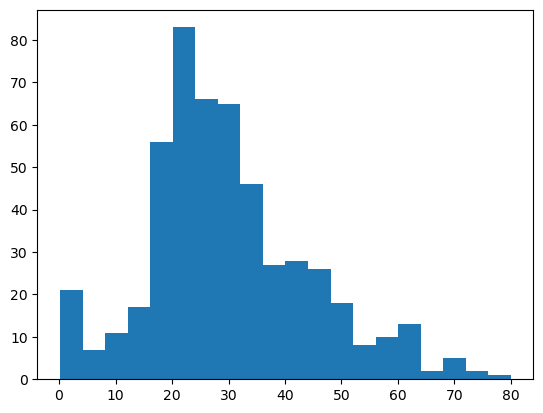

In [33]:
plt.hist(train['age'], bins=20)
plt.show()

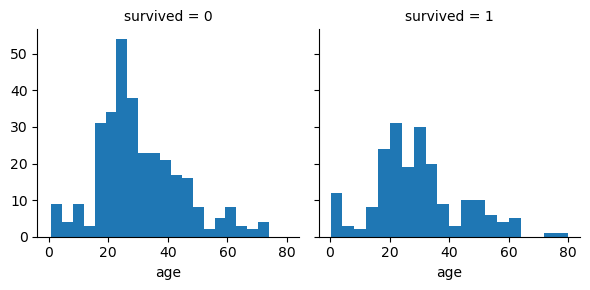

In [29]:
#age
g = sns.FacetGrid(train, col ='survived')
g.map(plt.hist,'age', bins=20)

In [151]:
import logging

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR) 

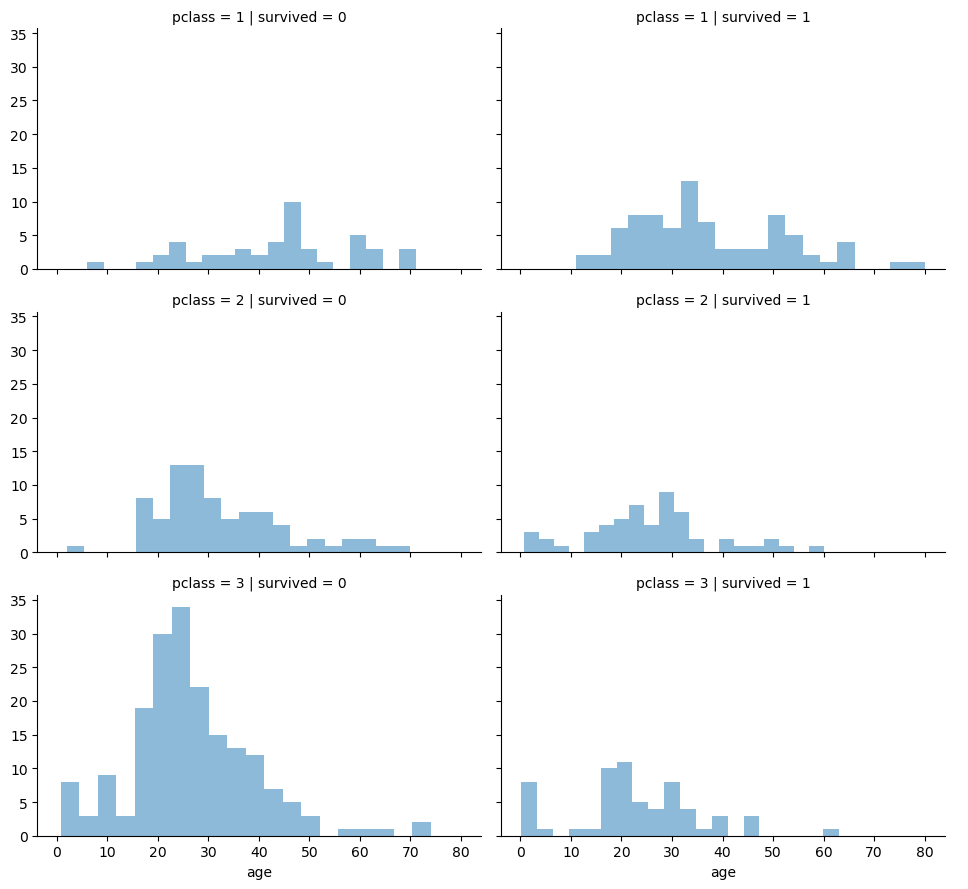

In [35]:
#pclasss
grid = sns.FacetGrid(train,col='survived',row='pclass', aspect=1.6)
grid.map(plt.hist,'age',alpha=.5, bins=20)
grid.add_legend()

- pclass에 따라 승객의 나이 분포 다름
- Pclass=2, Pclass=3에서 영아 승객은 대부분 생존
- Pclass=3인 승객수가 가장 많지만 대다수가 생존하지 못함

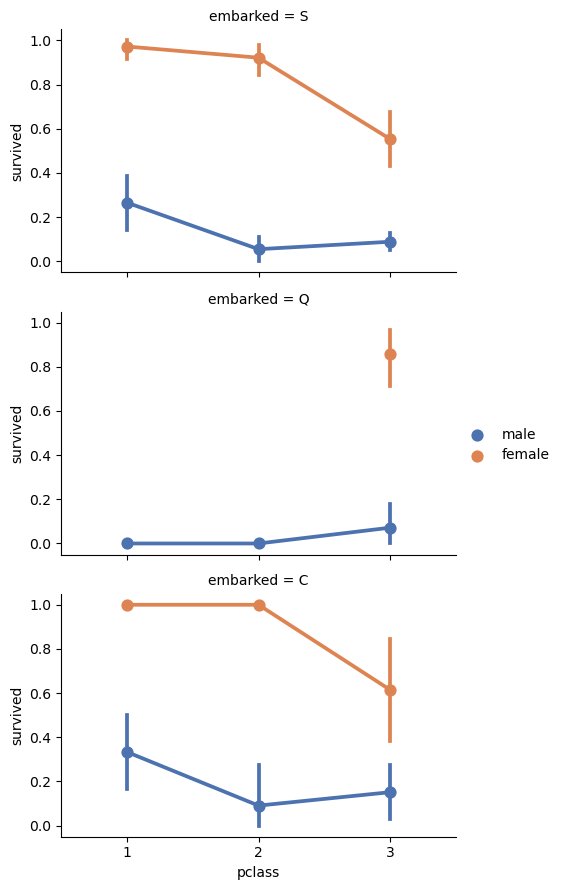

In [62]:
grid = sns.FacetGrid(train, row='embarked',  aspect=1.6)
grid.map(sns.pointplot, 'pclass', 'survived', 'gender', palette='deep',order=[1,2,3], hue_order=["male","female"])
grid.add_legend()

plt.show()

In [76]:
df = train[['gender','pclass','embarked','survived']]
grouped = df.groupby(['embarked','pclass','gender'])
gdf = grouped.mean()
gdf

survived
embarked pclass gender          
C        1      female  1.000000
                male    0.333333
         2      female  1.000000
                male    0.090909
         3      female  0.615385
                male    0.151515
Q        1      male    0.000000
         2      male    0.000000
         3      female  0.857143
                male    0.071429
S        1      female  0.972222
                male    0.265306
         2      female  0.921569
                male    0.054795
         3      female  0.553846
                male    0.088398

- 여성의 생존 비율 높음
- Embarked=S에서 남성 생존 비율 높음

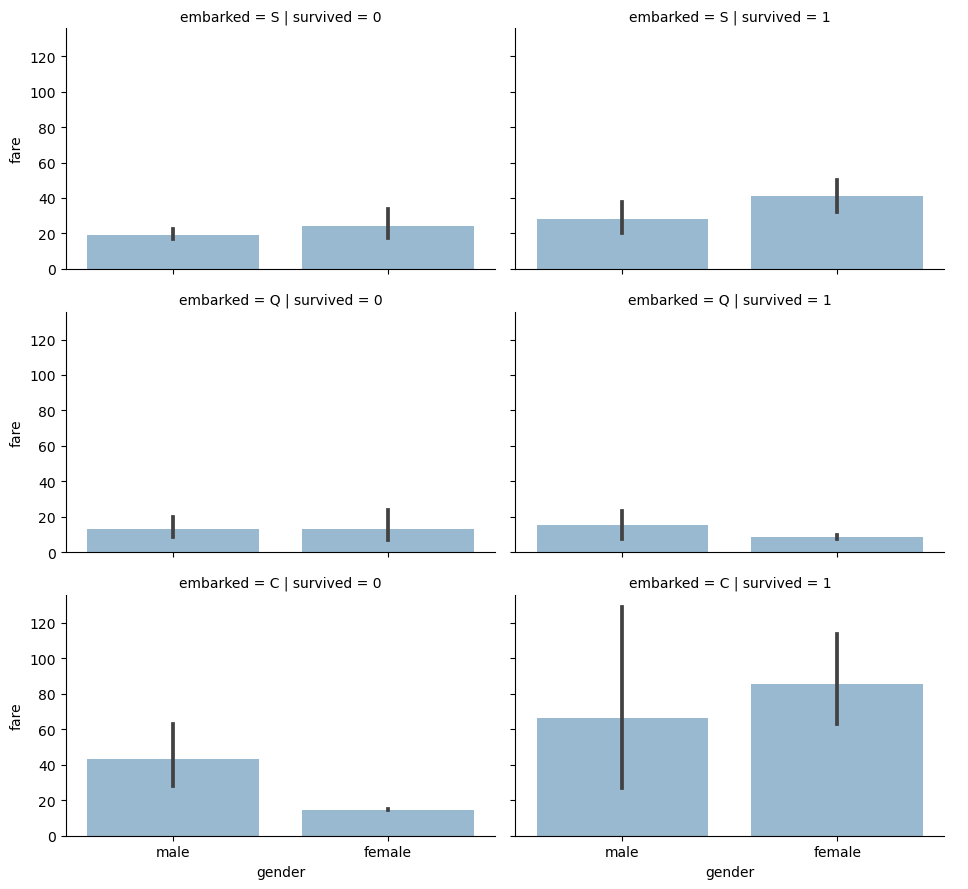

In [82]:
grid = sns.FacetGrid(train, row='embarked', col='survived',  aspect=1.6)
grid.map(sns.barplot, 'gender', 'fare', alpha=.5, order=["male","female"])
grid.add_legend()

plt.show()

#### Missing data

In [99]:
train.isnull().sum() , test.isnull().sum(), raw_test.isnull().sum()

(survived      0
 pclass        0
 gender        0
 age         129
 sibsp         0
 parch         0
 fare          0
 embarked      0
 title         0
 dtype: int64,
 survived     0
 pclass       0
 gender       0
 age         51
 sibsp        0
 parch        0
 fare         0
 embarked     1
 title        0
 dtype: int64,
 pclass       0
 gender       0
 age         83
 sibsp        0
 parch        0
 fare         1
 embarked     1
 title        0
 dtype: int64)

##### age
- title별 age 평균으로 결측치 대체

In [101]:
title_mean = train[['title','age']].groupby(['title'],as_index=False).mean()
title_mean

,title,age
0,Miss,21.899238
1,Mr,32.107394
2,Mrs,37.545455
3,Other,23.264286


In [102]:
cond= []

train[cond]

for i in range(len(title_mean.title)):
    train.loc[((train.title.values==title_mean.title[i]) & train['age'].isnull()), 'age'] = title_mean.age[i]
    test.loc[((test.title.values==title_mean.title[i])& test['age'].isnull()),'age'] = title_mean.age[i]
    raw_test.loc[((raw_test.title.values==title_mean.title[i])& raw_test['age'].isnull()),'age'] = title_mean.age[i]

In [103]:
train['age'].isnull().sum() , test['age'].isnull().sum(), raw_test['age'].isnull().sum()

(0, 0, 0)

##### embarked 
- 최빈값으로 대체

In [105]:
train.embarked.isnull().sum() , test.embarked.isnull().sum(), raw_test.embarked.isnull().sum()

(0, 1, 1)

In [106]:
train.embarked.value_counts()

S    455
C    128
Q     58
Name: embarked, dtype: int64

In [107]:
train.embarked.mode().values[0]

'S'

In [108]:
# embarked 결측치는 최빈값으로 대체
test['embarked'].fillna(train.embarked.mode().values[0],inplace = True)
raw_test['embarked'].fillna(train.embarked.mode().values[0],inplace = True)

In [109]:
train.embarked.isnull().sum() , test.embarked.isnull().sum(), raw_test.embarked.isnull().sum()

(0, 0, 0)

##### fare
- 중앙값으로 대체

In [111]:
train.fare.isnull().sum() , test.fare.isnull().sum(), raw_test.fare.isnull().sum()

(0, 0, 1)

In [112]:
#중앙값으로 대체
raw_test['fare'].fillna(train['fare'].median(),inplace=True)

In [113]:
train.fare.isnull().sum() , test.fare.isnull().sum(), raw_test.fare.isnull().sum()

(0, 0, 0)

#### New Features 

##### name title

In [155]:
train.name

812                                   Ohman, Miss. Velin
134                                  Buckley, Mr. Daniel
390                                    Jonsson, Mr. Carl
305                             Hassan, Mr. Houssein G N
203                                      Corn, Mr. Harry
                             ...                        
273                                    Davis, Miss. Mary
343                            Mulvihill, Miss. Bertha E
450    Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...
94                          Panula, Master. Urho Abraham
277                               Hunt, Mr. George Henry
Name: name, Length: 641, dtype: object

In [85]:
print(f'before: {train.shape , test.shape , raw_test.shape}')

train['title'] = train.name.map(lambda x : x.split(',')[1].split('.')[0])
test['title'] = test.name.map(lambda x : x.split(',')[1].split('.')[0])
raw_test['title'] = raw_test.name.map(lambda x : x.split(',')[1].split('.')[0])

print(f'after: {train.shape , test.shape , raw_test.shape}')

before: ((641, 10), (275, 10), (393, 9))
after: ((641, 10), (275, 10), (393, 9))


In [90]:
train.title.value_counts()

 Mr          370
 Miss        126
 Mrs         106
 Master       22
 Rev           4
 Dr            3
 Col           3
 Major         2
 Capt          1
 Mlle          1
 Ms            1
 Sir           1
 Jonkheer      1
Name: title, dtype: int64

In [91]:
list(train['title'].value_counts().index[:3])

[' Mr', ' Miss', ' Mrs']

In [92]:
def add_title(title):
    result = 'Other'
    try:
        if title in list(train['title'].value_counts().index[:3]):
            return title
        else:
            return result
    except:
        return result
    
train['title'] = train['title'].map(lambda x : add_title(x))
test['title'] = test['title'].map(lambda x : add_title(x))
raw_test['title'] = raw_test['title'].map(lambda x : add_title(x))

In [93]:
train['title'].unique(), test['title'].unique(), raw_test['title'].unique()

(array([' Miss', ' Mr', ' Mrs', 'Other'], dtype=object),
 array([' Mr', 'Other', ' Miss', ' Mrs'], dtype=object),
 array([' Miss', ' Mrs', ' Mr', 'Other'], dtype=object))

In [94]:
train['title'] = train['title'].map(lambda x : x.strip())
test['title'] = test['title'].map(lambda x : x.strip())
raw_test['title'] = raw_test['title'].map(lambda x : x.strip())

In [95]:
train.title.unique()

array(['Miss', 'Mr', 'Mrs', 'Other'], dtype=object)

In [ ]:
#name 삭제
print(f'before: {train.shape , test.shape , raw_test.shape}')

del train['name']
del test['name']
del raw_test['name']

print(f'after: {train.shape , test.shape , raw_test.shape}')

##### age 
- 연령대별로 범주화

In [122]:
train['AgeBand'] = pd.cut(train['age'],5)
train[['AgeBand','survived']].groupby(['AgeBand'],as_index=False).agg(['mean','sum','count'])

survived           
                      mean  sum count
AgeBand                              
(0.0902, 16.136]  0.446429   25    56
(16.136, 32.102]  0.410169  121   295
(32.102, 48.068]  0.298701   69   231
(48.068, 64.034]  0.510204   25    49
(64.034, 80.0]    0.200000    2    10

In [123]:
#age를 범주형으로 변환
for dataset in combine:    
    dataset.loc[ dataset['age'] <= 16, 'age'] = 0
    dataset.loc[(dataset['age'] > 16) & (dataset['age'] <= 32), 'age'] = 1
    dataset.loc[(dataset['age'] > 32) & (dataset['age'] <= 48), 'age'] = 2
    dataset.loc[(dataset['age'] > 48) & (dataset['age'] <= 64), 'age'] = 3
    dataset.loc[ dataset['age'] > 64, 'age'] = 4
train.head()

,survived,pclass,gender,age,sibsp,parch,fare,embarked,title,FamilySize,AgeBand
812,1,3,female,1.0,0,0,7.7750,S,Miss,1,"(16.136, 32.102]"
134,0,3,male,1.0,0,0,7.8208,Q,Mr,1,"(16.136, 32.102]"
390,1,3,male,1.0,0,0,7.8542,S,Mr,1,"(16.136, 32.102]"
305,0,3,male,0.0,0,0,18.7875,C,Mr,1,"(0.0902, 16.136]"
203,0,3,male,1.0,0,0,8.0500,S,Mr,1,"(16.136, 32.102]"


In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    641 non-null    int64   
 1   pclass      641 non-null    int64   
 2   gender      641 non-null    object  
 3   age         641 non-null    float64 
 4   sibsp       641 non-null    int64   
 5   parch       641 non-null    int64   
 6   fare        641 non-null    float64 
 7   embarked    641 non-null    object  
 8   title       641 non-null    object  
 9   FamilySize  641 non-null    int64   
 10  AgeBand     641 non-null    category
dtypes: category(1), float64(2), int64(5), object(3)
memory usage: 56.0+ KB


In [126]:
#age type 변경
train['age']=train.age.astype('int64')
test['age']=test.age.astype('int64')
raw_test['age']=raw_test.age.astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    641 non-null    int64   
 1   pclass      641 non-null    int64   
 2   gender      641 non-null    object  
 3   age         641 non-null    int64   
 4   sibsp       641 non-null    int64   
 5   parch       641 non-null    int64   
 6   fare        641 non-null    float64 
 7   embarked    641 non-null    object  
 8   title       641 non-null    object  
 9   FamilySize  641 non-null    int64   
 10  AgeBand     641 non-null    category
dtypes: category(1), float64(1), int64(6), object(3)
memory usage: 56.0+ KB


In [129]:
train[['age','AgeBand']]  #확인

,age,AgeBand
812,1,"(16.136, 32.102]"
134,1,"(16.136, 32.102]"
390,1,"(16.136, 32.102]"
305,0,"(0.0902, 16.136]"
203,1,"(16.136, 32.102]"
...,...,...
273,1,"(16.136, 32.102]"
343,1,"(16.136, 32.102]"
450,2,"(32.102, 48.068]"
94,0,"(0.0902, 16.136]"


In [130]:
# AgeBand 삭제
del train['AgeBand']

##### FamilySize 
- parch와 sibsp 이용

In [131]:
print(f'before: {train.shape , test.shape , raw_test.shape}')

combine = [train, test , raw_test]
for dataset in combine:
    dataset['FamilySize'] = dataset['parch'] + dataset['sibsp'] + 1 

train[['FamilySize','survived']].groupby(['FamilySize'],as_index=False).mean().sort_values(by='survived',ascending=False)

print(f'after: {train.shape , test.shape , raw_test.shape}')

before: ((641, 10), (275, 10), (393, 9))
after: ((641, 10), (275, 10), (393, 9))


##### IsAlone

- 1인가구인지?

In [134]:
print(f'before: {train.shape , test.shape , raw_test.shape}')

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1,'IsAlone']=1

print(f'after: {train.shape , test.shape , raw_test.shape}')

before: ((641, 11), (275, 11), (393, 10))
after: ((641, 11), (275, 11), (393, 10))


In [133]:
train[['IsAlone','survived']].groupby(['IsAlone'],as_index=False).mean()

,IsAlone,survived
0,0,0.504132
1,1,0.300752


### Data Encoding

In [140]:
from sklearn.preprocessing import OneHotEncoder

In [142]:
train.describe(exclude=np.number)  #범주형

,gender,embarked,title
count,641,641,641
unique,2,3,4
top,male,S,Mr
freq,407,455,370


In [144]:
train.isnull().sum().sum() ,test.isnull().sum().sum(), raw_test.isnull().sum().sum()

(0, 0, 0)

In [146]:
enc_cols = ['gender','embarked','title']
normal_cols = train.columns.difference(['gender','embarked','title'])

#raw_test용 (survived를 제외시킨 column)
normal_cols_ori = normal_cols      
normal_cols_ori = normal_cols_ori.drop('survived')

normal_cols , normal_cols_ori

(Index(['FamilySize', 'IsAlone', 'age', 'fare', 'parch', 'pclass', 'sibsp',
        'survived'],
       dtype='object'),
 Index(['FamilySize', 'IsAlone', 'age', 'fare', 'parch', 'pclass', 'sibsp'], dtype='object'))

In [148]:
print(f'before: {train.shape} / {test.shape} / {enc_raw_te.shape}')

enc = OneHotEncoder()

#train
tmp_tr = pd.DataFrame(                              
    enc.fit_transform(train[enc_cols]).toarray(),   
    columns = enc.get_feature_names_out()           
)
enc_tr = pd.concat(
    [train[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]    
    , axis=1
)

# # test
tmp_te = pd.DataFrame(
    enc.transform(test[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)
enc_te = pd.concat(
    [test[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

# raw_test
tmp_te = pd.DataFrame(
    enc.transform(raw_test[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)

enc_raw_te = pd.concat(
    [raw_test[normal_cols_ori].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

print(f'after: {enc_tr.shape} / {enc_te.shape} / {enc_raw_te.shape}')
enc_te.head()

before: (641, 11) / (275, 11) / (393, 16)
after: (641, 17) / (275, 17) / (393, 16)


,FamilySize,IsAlone,age,fare,parch,pclass,sibsp,survived,gender_female,gender_male,embarked_C,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Other
0,1,1,2,7.5750,0,3,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2,0,2,76.7292,0,1,1,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,0,3,81.8583,1,1,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,11,0,1,69.5500,2,3,8,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2,0,2,57.7500,0,1,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


#### target, feature 분리

In [154]:
#enc_tr
y_tr = enc_tr['survived']                   #타겟 데이터
X_tr = enc_tr.drop(['survived'], axis=1)    #Feature 데이터만

In [151]:
X_tr.head()

,FamilySize,IsAlone,age,fare,parch,pclass,sibsp,gender_female,gender_male,embarked_C,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Other
0,1,1,1,7.7750,0,3,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1,1,1,7.8208,0,3,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,1,1,7.8542,0,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,1,0,18.7875,0,3,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,1,1,8.0500,0,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [155]:
#enc_te
y_te = enc_te['survived']                   #타겟 데이터
X_te = enc_te.drop(['survived'], axis=1)    #Feature 데이터만

In [210]:
print(f'after: {X_tr.shape} / {X_te.shape} / {enc_raw_te.shape}')

after: (641, 16) / (275, 16) / (393, 16)


### Training

#### CatBoost


In [211]:
# !pip install catboost

In [157]:
from catboost import CatBoostClassifier

In [159]:
hp = {
    "random_state" : 42,
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}

model1 = CatBoostClassifier(**hp).fit(X_tr, y_tr)

In [160]:
#AUC
from sklearn.metrics import roc_curve, auc 

y_pred = model1.predict_proba(X_te)[:,1]   # 예측값 / proba : 확률 예측  > 0과 1사이에 있는 값이 나옴 > 이 값을 submit 파일에 올리면 됨
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.9074167791273055


#### Light GBM

In [170]:
from lightgbm import LGBMClassifier ,plot_importance

model2 = LGBMClassifier(random_state=42).fit(X_tr,y_tr)

In [162]:
from sklearn.metrics import roc_curve, auc

#AUC
y_pred = model2.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.8817757534862798


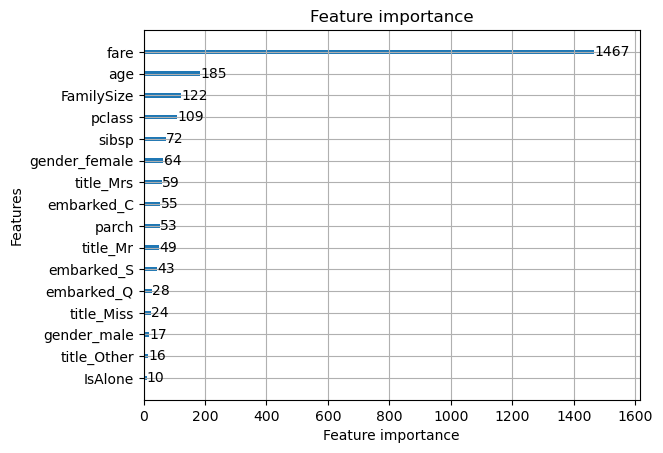

In [171]:
plot_importance(model2)
plt.show()

#### XGboost

In [166]:
from xgboost import XGBClassifier ,plot_importance

model3 = XGBClassifier(random_state=42).fit(X_tr,y_tr)

In [265]:
X_tr.shape , y_tr.shape , enc_te.shape

((641, 16), (641,), (275, 17))

In [266]:
y_pred = model3.predict_proba(X_te)[:,1]

In [164]:
from sklearn.metrics import roc_curve, auc

y_pred = model3.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.8888326585695006


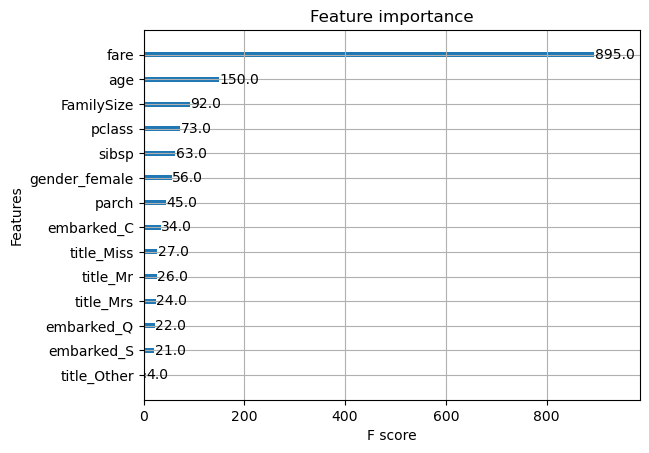

In [168]:
plot_importance(model3)
plt.show()

### Submission

In [172]:
#model1 사용
ori_te_pred = model1.predict_proba(enc_raw_te)[:,1]
ori_te_pred.shape

(393,)

In [173]:
ori_te_pred

array([0.88694496, 0.91877715, 0.86963106, 0.05780481, 0.94610475,
       0.84186767, 0.08192711, 0.07049167, 0.82137935, 0.05444658,
       0.07973417, 0.02100163, 0.6539678 , 0.74949839, 0.09522127,
       0.27778733, 0.14623439, 0.04731196, 0.03435647, 0.07049167,
       0.10705739, 0.04375636, 0.06398187, 0.12543003, 0.08083468,
       0.1124872 , 0.21678118, 0.63593113, 0.57417374, 0.05235736,
       0.75467952, 0.76255254, 0.07755942, 0.22515365, 0.25327749,
       0.1027752 , 0.93634161, 0.04169472, 0.14226321, 0.05383063,
       0.06015275, 0.9807044 , 0.10587906, 0.98481123, 0.05226485,
       0.04169472, 0.18910518, 0.07555397, 0.04421088, 0.04036829,
       0.57396802, 0.04008144, 0.96591918, 0.08340687, 0.75745971,
       0.90023775, 0.38095547, 0.08695934, 0.04169472, 0.15271445,
       0.9804994 , 0.63574214, 0.86070387, 0.04816505, 0.09725388,
       0.04375636, 0.57824201, 0.87430279, 0.08706995, 0.96612359,
       0.10006548, 0.63941438, 0.75020378, 0.89638896, 0.04860

In [175]:
submission['survived'] = ori_te_pred
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,0.886945
1,917,0.918777
2,918,0.869631
3,919,0.057805
4,920,0.946105
5,921,0.841868
6,922,0.081927
7,923,0.070492
8,924,0.821379
9,925,0.054447


In [ ]:
submission.to_csv(args.submission_csv, header=True, index=False)